In [2]:
import io
import os
import sys
import requests
from collections import OrderedDict 
import math
import random
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Embedding
import pandas as pd
import matplotlib.pyplot as plt

#Skip gram

In [1]:
pip install paddlepaddle-gpu==2.2.2 -i https://pypi.doubanio.com/simple/

Looking in indexes: https://pypi.doubanio.com/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435.4 MB 27 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_text8():
    with open("/content/drive/MyDrive/data/test/new1.txt", "r") as f:
        corpus = f.read().strip("\n")
    f.close()
    return corpus
corpus = load_text8()
#打印前800个字符，简要看一下这个语料的样子
print(corpus[:800])


recombination every day  abundant recombination in a virus during a single multi cellular host infectionas increasing numbers of full length viral sequences become available  recombinant or mosaic viruses are being recognized more frequently          recombination events have been demonstrated to be associated with viruses expanding their host range           or increasing their virulence        thus accompanying  or perhaps even being at the origin of  major changes during virus adaptation  it remains unclear  however  whether recombination events represent a highly frequent and significant phenomenon in the everyday life of these viruses why can t i visit  the ethics of visitation restrictions   lessons learned from sarsthe sudden emergence of severe acute respiratory syndrome  sars  in 


In [ ]:
#对语料进行预处理（分词）
def data_preprocess(corpus):
    #由于英文单词出现在句首的时候经常要大写，所以我们把所有英文字符都转换为小写，
    #以便对语料进行归一化处理（Apple vs apple等）
    corpus = corpus.strip().lower()
    corpus = corpus.split()
    return corpus
corpus = data_preprocess(corpus)
print(corpus[:50])
hi=corpus

['recombination', 'every', 'day', 'abundant', 'recombination', 'in', 'a', 'virus', 'during', 'a', 'single', 'multi', 'cellular', 'host', 'infectionas', 'increasing', 'numbers', 'of', 'full', 'length', 'viral', 'sequences', 'become', 'available', 'recombinant', 'or', 'mosaic', 'viruses', 'are', 'being', 'recognized', 'more', 'frequently', 'recombination', 'events', 'have', 'been', 'demonstrated', 'to', 'be', 'associated', 'with', 'viruses', 'expanding', 'their', 'host', 'range', 'or', 'increasing', 'their']


In [ ]:
#构造词典，统计每个词的频率，并根据频率将每个词转换为一个整数id
def build_dict(corpus):
    #首先统计每个不同词的频率（出现的次数），使用一个词典记录
    word_freq_dict = dict()
    for word in corpus:
        if word not in word_freq_dict:
            word_freq_dict[word] = 0
        word_freq_dict[word] += 1
    #将这个词典中的词，按照出现次数排序，出现次数越高，排序越靠前
    #一般来说，出现频率高的高频词往往是：I，the，you这种代词，而出现频率低的词，往往是一些名词，如：nlp
    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)    
    #构造3个不同的词典，分别存储，
    #每个词到id的映射关系：word2id_dict
    #每个id出现的频率：word2id_freq
    #每个id到词典映射关系：id2word_dict
    word2id_dict = dict()
    word2id_freq = dict()
    id2word_dict = dict()
    #按照频率，从高到低，开始遍历每个单词，并为这个单词构造一个独一无二的id
    for word, freq in word_freq_dict:
        curr_id = len(word2id_dict)
        word2id_dict[word] = curr_id
        word2id_freq[word2id_dict[word]] = freq
        id2word_dict[curr_id] = word
    return word2id_freq, word2id_dict, id2word_dict
word2id_freq, word2id_dict, id2word_dict = build_dict(corpus)
vocab_size = len(word2id_freq)
print("there are totoally %d different words in the corpus" % vocab_size)
for _, (word, word_id) in zip(range(50), word2id_dict.items()):
    print("word %s, its id %d, its word freq %d" % (word, word_id, word2id_freq[word_id]))


there are totoally 308637 different words in the corpus
word the, its id 0, its word freq 1363136
word of, its id 1, its word freq 1087170
word and, its id 2, its word freq 983901
word in, its id 3, its word freq 700514
word to, its id 4, its word freq 579726
word a, its id 5, its word freq 480478
word is, its id 6, its word freq 278644
word with, its id 7, its word freq 253034
word for, its id 8, its word freq 251788
word covid, its id 9, its word freq 240991
word as, its id 10, its word freq 213808
word are, its id 11, its word freq 170359
word that, its id 12, its word freq 168587
word by, its id 13, its word freq 158399
word on, its id 14, its word freq 153602
word have, its id 15, its word freq 123685
word has, its id 16, its word freq 122842
word disease, its id 17, its word freq 121849
word from, its id 18, its word freq 116874
word sars, its id 19, its word freq 116370
word cov, its id 20, its word freq 115233
word health, its id 21, its word freq 115016
word or, its id 22, its

In [ ]:
#把语料转换为id序列
def convert_corpus_to_id(corpus, word2id_dict):
    #使用一个循环，将语料中的每个词替换成对应的id，以便于神经网络进行处理
    corpus = [word2id_dict[word] for word in corpus]
    return corpus
corpus = convert_corpus_to_id(corpus, word2id_dict)
print("%d tokens in the corpus" % len(corpus))
print(corpus[:50])


26898847 tokens in the corpus
[2922, 665, 435, 3234, 2922, 3, 5, 34, 52, 5, 256, 824, 509, 177, 21382, 291, 880, 1, 1123, 1329, 62, 1113, 278, 258, 1690, 22, 7154, 90, 11, 175, 728, 48, 850, 2922, 459, 15, 29, 690, 4, 30, 78, 7, 90, 2913, 49, 177, 359, 22, 291, 49]


In [ ]:
#使用二次采样算法（subsampling）处理语料，强化训练效果
def subsampling(corpus, word2id_freq):
    
    #这个discard函数决定了一个词会不会被替换，这个函数是具有随机性的，每次调用结果不同
    #如果一个词的频率很大，那么它被遗弃的概率就很大
    def discard(word_id):
        return random.uniform(0, 1) < 1 - math.sqrt(
            1e-4 / word2id_freq[word_id] * len(corpus))

    corpus = [word for word in corpus if not discard(word)]
    return corpus
corpus = subsampling(corpus, word2id_freq)
print("%d tokens in the corpus" % len(corpus))
print(corpus[:50])


13119109 tokens in the corpus
[2922, 3234, 2922, 34, 52, 256, 824, 509, 177, 21382, 1, 1123, 1329, 1113, 258, 1690, 7154, 11, 175, 850, 2922, 690, 78, 2913, 49, 2159, 5718, 2800, 230, 936, 283, 2358, 490, 1565, 659, 2922, 1102, 249, 1120, 196, 1804, 3039, 156, 90, 1645, 2874, 2066, 11406, 839, 1547]


In [ ]:
#构造数据，准备模型训练
#max_window_size代表了最大的window_size的大小，程序会根据max_window_size从左到右扫描整个语料
#negative_sample_num代表了对于每个正样本，我们需要随机采样多少负样本用于训练，
#一般来说，negative_sample_num的值越大，训练效果越稳定，但是训练速度越慢。 
def build_data(corpus, word2id_dict, word2id_freq, max_window_size = 3, 
               negative_sample_num = 6):
    
    #使用一个list存储处理好的数据
    dataset = []
    center_word_idx=0

    #从左到右，开始枚举每个中心点的位置
    while center_word_idx < 3000000:
        #以max_window_size为上限，随机采样一个window_size，这样会使得训练更加稳定
        window_size = random.randint(1, max_window_size)
        #当前的中心词就是center_word_idx所指向的词，可以当作正样本
        positive_word = corpus[center_word_idx]

        #以当前中心词为中心，左右两侧在window_size内的词就是上下文
        context_word_range = (max(0, center_word_idx - window_size), min(len(corpus) - 1, center_word_idx + window_size))
        context_word_candidates = [corpus[idx] for idx in range(context_word_range[0], context_word_range[1]+1) if idx != center_word_idx]

        #对于每个正样本来说，随机采样negative_sample_num个负样本，用于训练
        for context_word in context_word_candidates:
            #首先把（上下文，正样本，label=1）的三元组数据放入dataset中，
            #这里label=1表示这个样本是个正样本
            dataset.append((context_word, positive_word, 1))

            #开始负采样
            i = 0
            while i < negative_sample_num:
                negative_word_candidate = random.randint(0, vocab_size-1)

                if negative_word_candidate is not positive_word:
                    #把（上下文，负样本，label=0）的三元组数据放入dataset中，
                    #这里label=0表示这个样本是个负样本
                    dataset.append((context_word, negative_word_candidate, 0))
                    i += 1
        
        center_word_idx = min(len(corpus) - 1, center_word_idx + window_size)
        if center_word_idx == (len(corpus) - 1):
            center_word_idx += 1
        if center_word_idx % 100000 == 0:
            print(center_word_idx)
    
    return dataset

dataset = build_data(corpus, word2id_dict, word2id_freq)
for _, (context_word, target_word, label) in zip(range(50), dataset):
    print("center_word %s, target %s, label %d" % (id2word_dict[context_word],
                                                   id2word_dict[target_word], label))


200000
400000
500000
600000
900000
1000000
1100000
1400000
1500000
1600000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
3000000
center_word every, target recombination, label 1
center_word every, target chlorite, label 0
center_word every, target ergodic, label 0
center_word every, target trailer, label 0
center_word every, target trockel, label 0
center_word every, target polyanion, label 0
center_word every, target arabiacanada, label 0
center_word day, target recombination, label 1
center_word day, target member, label 0
center_word day, target millets, label 0
center_word day, target uncapped, label 0
center_word day, target conspecific, label 0
center_word day, target bernardine, label 0
center_word day, target glimmers, label 0
center_word abundant, target recombination, label 1
center_word abundant, target protocolwe, label 0
center_word abundant, target bozen, label 0
center_word abundant, target minks, label 0
center_word abundant, target behaviorswhen, labe

In [ ]:
#构造mini-batch，准备对模型进行训练
#我们将不同类型的数据放到不同的tensor里，便于神经网络进行处理
#并通过numpy的array函数，构造出不同的tensor来，并把这些tensor送入神经网络中进行训练
def build_batch(dataset, batch_size, epoch_num):
    
    #center_word_batch缓存batch_size个中心词
    center_word_batch = []
    #target_word_batch缓存batch_size个目标词（可以是正样本或者负样本）
    target_word_batch = []
    #label_batch缓存了batch_size个0或1的标签，用于模型训练
    label_batch = []

    for epoch in range(epoch_num):
        #每次开启一个新epoch之前，都对数据进行一次随机打乱，提高训练效果
        random.shuffle(dataset)
        
        for center_word, target_word, label in dataset:
            #遍历dataset中的每个样本，并将这些数据送到不同的tensor里
            center_word_batch.append([center_word])
            target_word_batch.append([target_word])
            label_batch.append(label)

            #当样本积攒到一个batch_size后，我们把数据都返回回来
            #在这里我们使用numpy的array函数把list封装成tensor
            #并使用python的迭代器机制，将数据yield出来
            #使用迭代器的好处是可以节省内存
            if len(center_word_batch) == batch_size:
                yield np.array(center_word_batch).astype("int64"), \
                    np.array(target_word_batch).astype("int64"), \
                    np.array(label_batch).astype("float32")
                center_word_batch = []
                target_word_batch = []
                label_batch = []

    if len(center_word_batch) > 0:
        yield np.array(center_word_batch).astype("int64"), \
            np.array(target_word_batch).astype("int64"), \
            np.array(label_batch).astype("float32")

# for _, batch in zip(range(10), build_batch(dataset, 128, 3)):
#     print(batch)


In [ ]:
#定义skip-gram训练网络结构
#这里我们使用的是paddlepaddle的1.8.0版本
#一般来说，在使用fluid训练的时候，我们需要通过一个类来定义网络结构，这个类继承了fluid.dygraph.Layer
class SkipGram(fluid.dygraph.Layer):
    def __init__(self, vocab_size, embedding_size, init_scale=0.1):
        #vocab_size定义了这个skipgram这个模型的词表大小
        #embedding_size定义了词向量的维度是多少
        #init_scale定义了词向量初始化的范围，一般来说，比较小的初始化范围有助于模型训练
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        #使用paddle.fluid.dygraph提供的Embedding函数，构造一个词向量参数
        #这个参数的大小为：[self.vocab_size, self.embedding_size]
        #数据类型为：float32
        #这个参数的名称为：embedding_para
        #这个参数的初始化方式为在[-init_scale, init_scale]区间进行均匀采样
        self.embedding = Embedding(
            size=[self.vocab_size, self.embedding_size],
            dtype='float32',
            param_attr=fluid.ParamAttr(
                name='embedding_para',
                initializer=fluid.initializer.UniformInitializer(
                    low=-0.5/embedding_size, high=0.5/embedding_size)))

        #使用paddle.fluid.dygraph提供的Embedding函数，构造另外一个词向量参数
        #这个参数的大小为：[self.vocab_size, self.embedding_size]
        #数据类型为：float32
        #这个参数的名称为：embedding_para_out
        #这个参数的初始化方式为在[-init_scale, init_scale]区间进行均匀采样
        #跟上面不同的是，这个参数的名称跟上面不同，因此，
        #embedding_para_out和embedding_para虽然有相同的shape，但是权重不共享
        self.embedding_out = Embedding(
            size=[self.vocab_size, self.embedding_size],
            dtype='float32',
            param_attr=fluid.ParamAttr(
                name='embedding_out_para',
                initializer=fluid.initializer.UniformInitializer(
                    low=-0.5/embedding_size, high=0.5/embedding_size)))

    #定义网络的前向计算逻辑
    #center_words是一个tensor（mini-batch），表示中心词
    #target_words是一个tensor（mini-batch），表示目标词
    #label是一个tensor（mini-batch），表示这个词是正样本还是负样本（用0或1表示）
    #用于在训练中计算这个tensor中对应词的同义词，用于观察模型的训练效果
    def forward(self, center_words, target_words, label):
        #首先，通过embedding_para（self.embedding）参数，将mini-batch中的词转换为词向量
        #这里center_words和eval_words_emb查询的是一个相同的参数
        #而target_words_emb查询的是另一个参数
        center_words_emb = self.embedding(center_words)
        target_words_emb = self.embedding_out(target_words)

        #center_words_emb = [batch_size, embedding_size]
        #target_words_emb = [batch_size, embedding_size]
        #我们通过点乘的方式计算中心词到目标词的输出概率，并通过sigmoid函数估计这个词是正样本还是负样本的概率。
        word_sim = fluid.layers.elementwise_mul(center_words_emb, target_words_emb)
        word_sim = fluid.layers.reduce_sum(word_sim, dim = -1)
        word_sim = fluid.layers.reshape(word_sim, shape=[-1])
        pred = fluid.layers.sigmoid(word_sim)

        #通过估计的输出概率定义损失函数，注意我们使用的是sigmoid_cross_entropy_with_logits函数
        #将sigmoid计算和cross entropy合并成一步计算可以更好的优化，所以输入的是word_sim，而不是pred
        
        loss = fluid.layers.sigmoid_cross_entropy_with_logits(word_sim, label)
        loss = fluid.layers.reduce_mean(loss)

        #返回前向计算的结果，飞桨会通过backward函数自动计算出反向结果。
        return pred, loss


In [ ]:
#开始训练，定义一些训练过程中需要使用的超参数
batch_size = 256                                                                                                                                                                                                                                                                                                                                                                                                                                                              
epoch_num = 10
embedding_size = 200
step = 0
learning_rate = 0.0002
record=[]
steps=[]
#定义一个使用word-embedding计算cos的函数
def get_cos(query1_token, query2_token, embed):
    W = embed
    x = W[word2id_dict[query1_token]]
    y = W[word2id_dict[query2_token]]
    cos = np.dot(x, y) / np.sqrt(np.sum(y * y) * np.sum(x * x) + 1e-9)
    flat = cos.flatten()
    print("单词1 %s 和单词2 %s 的cos结果为 %f" %(query1_token, query2_token, cos))

#将模型放到GPU上训练（fluid.CUDAPlace(0)），如果需要指定CPU，则需要改为fluid.CPUPlace()
with fluid.dygraph.guard(fluid.CUDAPlace(0)):
    #通过我们定义的SkipGram类，来构造一个Skip-gram模型网络
    skip_gram_model = SkipGram(vocab_size, embedding_size)
    #构造训练这个网络的优化器
    adam = fluid.optimizer.AdamOptimizer(learning_rate=learning_rate, parameter_list=skip_gram_model.parameters())


    #使用build_batch函数，以mini-batch为单位，遍历训练数据，并训练网络
    for center_words, target_words, label in build_batch(
        dataset, batch_size, epoch_num):
        #使用fluid.dygraph.to_variable函数，将一个numpy的tensor，转换为飞桨可计算的tensor
        center_words_var = fluid.dygraph.to_variable(center_words)
        target_words_var = fluid.dygraph.to_variable(target_words)
        label_var = fluid.dygraph.to_variable(label)

        #将转换后的tensor送入飞桨中，进行一次前向计算，并得到计算结果
        pred, loss = skip_gram_model(
            center_words_var, target_words_var, label_var)

        #通过backward函数，让程序自动完成反向计算
        loss.backward()

        #通过minimize函数，让程序根据loss，完成一步对参数的优化更新
        adam.minimize(loss)
        #使用clear_gradients函数清空模型中的梯度，以便于下一个mini-batch进行更新
        skip_gram_model.clear_gradients()

        #每经过100个mini-batch，打印一次当前的loss，看看loss是否在稳定下降
        step += 1
        if step % 100 == 0:
            print("step %d, loss %.3f" % (step, loss.numpy()[0]))
            record.append(loss.numpy()[0])
            steps.append(step)

        #经过10000个mini-batch，打印一次模型对eval_words中的10个词计算的同义词
        #这里我们使用词和词之间的向量点积作为衡量相似度的方法
        #我们只打印了5个最相似的词
      
        if step==500000:
          break
        
            


step 20800, loss 0.173
step 20900, loss 0.304
step 21000, loss 0.317
step 21100, loss 0.192
step 21200, loss 0.260
step 21300, loss 0.144
step 21400, loss 0.238
step 21500, loss 0.187
step 21600, loss 0.144
step 21700, loss 0.241
step 21800, loss 0.146
step 21900, loss 0.220
step 22000, loss 0.179
step 22100, loss 0.183
step 22200, loss 0.152
step 22300, loss 0.149
step 22400, loss 0.221
step 22500, loss 0.167
step 22600, loss 0.195
step 22700, loss 0.190
step 22800, loss 0.234
step 22900, loss 0.171
step 23000, loss 0.129
step 23100, loss 0.144
step 23200, loss 0.176
step 23300, loss 0.149
step 23400, loss 0.176
step 23500, loss 0.246
step 23600, loss 0.203
step 23700, loss 0.163
step 23800, loss 0.136
step 23900, loss 0.236
step 24000, loss 0.200
step 24100, loss 0.170
step 24200, loss 0.148
step 24300, loss 0.241
step 24400, loss 0.177
step 24500, loss 0.213
step 24600, loss 0.155
step 24700, loss 0.183
step 24800, loss 0.192
step 24900, loss 0.132
step 25000, loss 0.195
step 25100,

KeyboardInterrupt: ignored

Text(0, 0.5, 'loss rate')

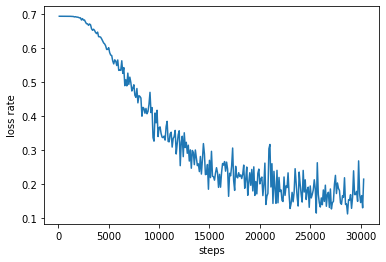

In [ ]:
plt.plot(steps,record)
plt.xlabel('steps')
plt.ylabel("loss rate")

#4.1

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


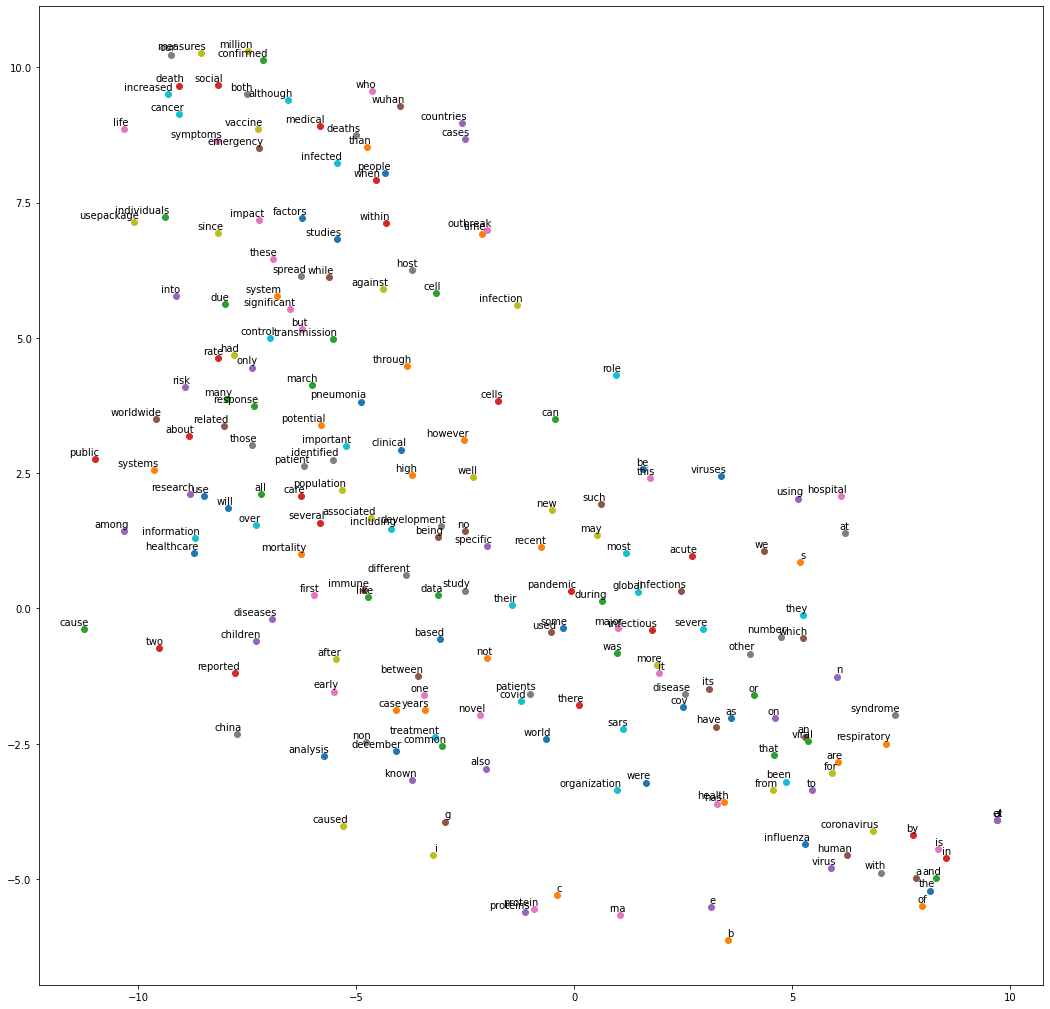

In [ ]:
# 1.4 实现词向量可视化
# 对与可视化相关的引入库做了初始化，具体说明如下：
# ①通过设置mpl的值让p|ot能够显示中文信息。
# ②Scikit-learn（也称为sklearn）库的t-SNE算法模块，作用是非对称降维。
#       t-SNE算法结合t分布，将高维空间的数据点映射到低维空间的距离，主要用于可视化和理解高维数据。
#
# 将词典中的词嵌入向量转成单位向量（只有方向)，然后将它们通过t-SNE算法降维映射到二维平面中进行显示。
def plot_with_labels(low_dim_embs, labels, filename='./data/tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                     ha='right', va='bottom')
    
 
final_embeddings = np.load("/content/drive/MyDrive/data/test/embedding2.npy")[:1000]
tsne = manifold.TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 200  # 输出100个词
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id2word_dict[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# 4.3

In [ ]:
#定义一个使用word-embedding计算cos的函数
def get_cos(query1_token, query2_token, embed):
    W = embed
    x = W[word2id_dict[query1_token]]
    y = W[word2id_dict[query2_token]]
    cos = np.dot(x, y) / np.sqrt(np.sum(y * y) * np.sum(x * x) + 1e-9)
    flat = cos.flatten()
    print("单词1 %s 和单词2 %s 的cos结果为 %f" %(query1_token, query2_token, cos) )

a = np.load('/content/drive/MyDrive/data/test/embedding2.npy') 

get_cos("covid","the",a)
get_cos('covid','of',a)
get_cos('covid','cyclospora',a)

单词1 covid 和单词2 the 的cos结果为 0.934298
单词1 covid 和单词2 of 的cos结果为 0.942497
单词1 covid 和单词2 cyclospora 的cos结果为 0.901609


In [ ]:

covid=a[word2id_dict['coronavirus']]
def coss(x,y):
  return  np.dot(x, y) / np.sqrt(np.sum(y * y) * np.sum(x * x) + 1e-9)


t=0
b=[]
for i in a:
  
  if coss(i,covid)>0.97:
    print(coss(i,covid))
    b.append(t)
  t=t+1  

    
#for matrix in a:

print(b)

0.9705671408235766
0.9753234011544809
0.9728239273325876
0.9806179665727032
0.9719329213692922
0.9730807678696262
0.9709319646598096
0.9709104255528899
0.9756513849429445
0.9755940528094351
0.9702997710567829
0.9751797650597022
0.9713835182360591
0.9749899622451661
0.9999999246736633
0.976510830811308
0.977721629178574
0.9733215128857088
0.9718809263680871
0.9720785871876084
0.9806521918831173
0.972213026024982
0.970532009576607
[1, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 20, 21, 25, 28, 29, 31, 34, 35, 39, 55, 62, 130]


In [ ]:
for i in b:

  print(id2word_dict[i])

of
a
is
with
for
as
are
that
by
has
disease
cov
health
an
coronavirus
been
respiratory
virus
which
severe
human
viral
influenza


In [ ]:
print(high)
high=a[:5]
def get_min(m):
  min=m[0]
  for t in m[1:]:
    if coss(t,covid)<coss(min,covid):
      min=t

  return min

In [ ]:
t=np.where(a==high[4])
print(t)

In [ ]:
print(id2word_dict[43755])


cyclospora


In [ ]:
print(embedding_matrix.shape)

(308637, 200)
